Poker simulation 

In [1]:
from typing import Tuple, Optional, Literal, overload, TypeVar, Generic
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from itertools import combinations
import tqdm

# Card = (rank: int, suit: str)
Card = Tuple[int, str]
POKER_HANDS = [
    "High Card", "One Pair", "Two Pair", "Three of a Kind",
    "Straight", "Flush", "Full House", "Four of a Kind",
    "Straight Flush", "Royal Flush"
]

SUITS = ['S', 'H', 'D', 'C']
RANKS = list(range(2, 15))  # 2–14

# Type variable for hand size
T = TypeVar('T', bound=int)

def card_to_str(card: Card) -> str:
    rank, suit = card
    rank_str = {11: 'J', 12: 'Q', 13: 'K', 14: 'A'}.get(rank, str(rank))
    suit_symbols = {'S': '♠', 'H': '♥', 'D': '♦', 'C': '♣'}
    return f"{rank_str}{suit_symbols.get(suit, suit)}"

class Hand(Generic[T]):
    def __init__(self, size: T, cards: Optional[list[Card]] = None):
        if cards is not None:
            self.hand: np.ndarray = np.array(cards, dtype=object)
        else:
            self.hand = self.generate_poker_hand(size)
        self.value: Optional[int] = None
        self.best_five: Optional[np.ndarray] = None

    def __repr__(self) -> str:
        return '[ ' + ' '.join(card_to_str(card) for card in self.hand) + ' ]'

    @staticmethod
    def generate_poker_hand(n: int) -> np.ndarray:
        deck: list[Card] = [(rank, suit) for rank in RANKS for suit in SUITS]
        indices = np.random.choice(len(deck), size=n, replace=False)
        return np.array([deck[i] for i in indices], dtype=object)

    def set_value(self, value: int, best_five: np.ndarray) -> None:
        self.value = value
        self.best_five = best_five

    def __add__(self, other: 'Hand') -> 'Hand':
        combined = np.concatenate([self.hand, other.hand])
        return Hand(len(combined), list(combined))

    # Comparison by hand strength
    def __lt__(self, other: 'Hand') -> bool: return self.value < other.value
    def __le__(self, other: 'Hand') -> bool: return self.value <= other.value
    def __eq__(self, other: 'Hand') -> bool: return self.value == other.value
    def __ne__(self, other: 'Hand') -> bool: return self.value != other.value
    def __gt__(self, other: 'Hand') -> bool: return self.value > other.value
    def __ge__(self, other: 'Hand') -> bool: return self.value >= other.value

def evaluate_five(cards: list[Card]) -> int:
    ranks = sorted([r for r, _ in cards], reverse=True)
    suits = [s for _, s in cards]
    rank_counts = Counter(ranks)
    counts = sorted(rank_counts.values(), reverse=True)
    unique_ranks = sorted(set(ranks), reverse=True)

    is_flush = len(set(suits)) == 1
    is_straight = (
        len(unique_ranks) == 5 and unique_ranks[0] - unique_ranks[4] == 4
    ) or unique_ranks == [14, 5, 4, 3, 2]  # Wheel

    # Royal Flush
    if is_flush and unique_ranks == [14, 13, 12, 11, 10]:
        return 9
    # Straight Flush
    if is_flush and is_straight:
        return 8
    # Four of a Kind
    if 4 in counts:
        return 7
    # Full House
    if 3 in counts and 2 in counts:
        return 6
    # Flush
    if is_flush:
        return 5
    # Straight
    if is_straight:
        return 4
    # Three of a Kind
    if 3 in counts:
        return 3
    # Two Pair
    if counts.count(2) == 2:
        return 2
    # One Pair
    if 2 in counts:
        return 1
    # High Card
    return 0


def get_possible_hands(hand: Hand, river: Hand) -> list[list[Card]]:
    cards = list(np.concatenate([hand.hand, river.hand]))
    return [list(c) for c in combinations(cards, 5)]

def make_best_hand(hand: Hand, river: Hand) -> Hand:
    possible_hands = get_possible_hands(hand, river)
    best_value = -1
    best_five: Optional[list[Card]] = None
    for cards in possible_hands:
        value = evaluate_five(cards)
        if value > best_value:
            best_value = value
            best_five = cards
    hand.set_value(best_value, np.array(best_five, dtype=object))
    return hand

def simulation7(num_trials: int = 10000) -> np.ndarray:
    stats = np.zeros(len(POKER_HANDS), dtype=int)
    for _ in tqdm.trange(num_trials):
        player = Hand(2)
        river = Hand(5)
        A = make_best_hand(player, river)
        stats[A.value] += 1
    return stats

def simulation5(num_trials: int = 10000) -> np.ndarray:
    stats = np.zeros(len(POKER_HANDS), dtype=int)
    for _ in tqdm.trange(num_trials):
        full_hand = Hand(5)
        value = evaluate_five(full_hand.hand.tolist())
        stats[value] += 1
    return stats


In [2]:

from typing import List, Tuple
from itertools import combinations


# Import your evaluate_five and make_best_hand functions here if they are in another module
# from your_module import evaluate_five, make_best_hand


def best_of_seven(cards: List[Card]) -> Tuple[int, List[int]]:
    best_value = -1
    best_kickers = []
    for combo in combinations(cards, 5):
        value = evaluate_five(list(combo))
        if value > best_value:
            best_value = value
    return best_value, best_kickers



def test_full_deck_unique():
    deck = [(r, s) for r in RANKS for s in SUITS]
    assert len(deck) == 52
    assert len(set(deck)) == 52

def test_royal_flush():
    cards = [(10, 'H'), (11, 'H'), (12, 'H'), (13, 'H'), (14, 'H'), (2, 'D'), (3, 'S')]
    value, _ = best_of_seven(cards)
    assert value == 9

def test_straight_flush():
    cards = [(9, 'D'), (8, 'D'), (7, 'D'), (6, 'D'), (5, 'D'), (2, 'H'), (14, 'C')]
    value, _ = best_of_seven(cards)
    assert value == 8

def test_four_of_a_kind():
    cards = [(9, 'S'), (9, 'H'), (9, 'D'), (9, 'C'), (13, 'H'), (2, 'D'), (5, 'C')]
    value, _ = best_of_seven(cards)
    assert value == 7

def test_full_house():
    cards = [(8, 'S'), (8, 'H'), (8, 'D'), (11, 'C'), (11, 'H'), (4, 'S'), (2, 'C')]
    value, _ = best_of_seven(cards)
    assert value == 6

def test_flush():
    cards = [(2, 'C'), (6, 'C'), (9, 'C'), (11, 'C'), (13, 'C'), (4, 'H'), (8, 'D')]
    value, _ = best_of_seven(cards)
    assert value == 5

def test_straight():
    cards = [(10, 'H'), (9, 'D'), (8, 'C'), (7, 'S'), (6, 'H'), (2, 'C'), (3, 'D')]
    value, _ = best_of_seven(cards)
    assert value == 4

def test_wheel_straight():
    cards = [(14, 'H'), (2, 'D'), (3, 'S'), (4, 'H'), (5, 'H'), (9, 'D'), (11, 'C')]
    value, _ = best_of_seven(cards)
    assert value == 4

def test_three_of_a_kind():
    cards = [(12, 'S'), (12, 'H'), (12, 'D'), (2, 'C'), (9, 'H'), (4, 'S'), (5, 'D')]
    value, _ = best_of_seven(cards)
    assert value == 3

def test_two_pair():
    cards = [(13, 'S'), (13, 'D'), (3, 'H'), (3, 'C'), (6, 'D'), (10, 'H'), (2, 'H')]
    value, _ = best_of_seven(cards)
    assert value == 2

def test_one_pair():
    cards = [(14, 'H'), (14, 'S'), (5, 'C'), (8, 'D'), (11, 'H'), (3, 'C'), (6, 'S')]
    value, _ = best_of_seven(cards)
    assert value == 1

def test_high_card():
    cards = [(14, 'H'), (13, 'C'), (10, 'D'), (6, 'S'), (2, 'H'), (4, 'D'), (9, 'S')]
    value, _ = best_of_seven(cards)
    assert value == 0


def run_tests():
    test_full_deck_unique()
    test_royal_flush()
    test_straight_flush()
    test_four_of_a_kind()
    test_full_house()
    test_flush()
    test_straight()
    test_wheel_straight()
    test_three_of_a_kind()
    test_two_pair()
    test_one_pair()
    test_high_card()

run_tests()


100%|██████████| 100000/100000 [00:22<00:00, 4406.59it/s]


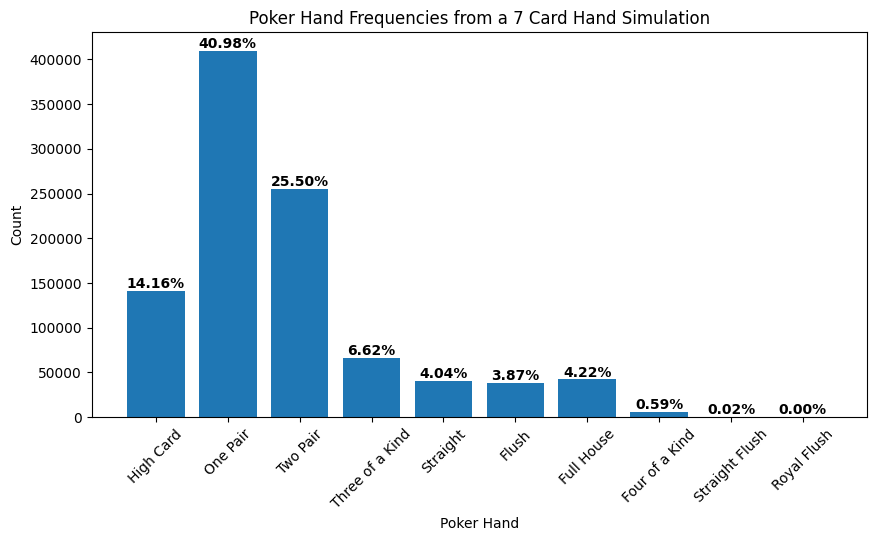

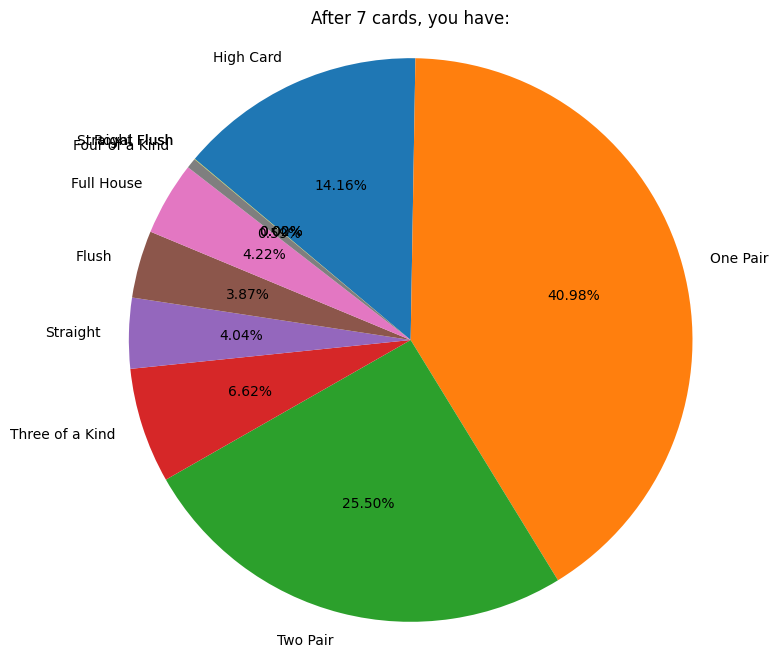

,Hand,Count,Frequency (%)
0,One Pair,409785,40.9785
1,Two Pair,255006,25.5006
2,High Card,141572,14.1572
3,Three of a Kind,66182,6.6182
4,Full House,42193,4.2193
5,Straight,40447,4.0447
6,Flush,38679,3.8679
7,Four of a Kind,5871,0.5871
8,Straight Flush,242,0.0242
9,Royal Flush,23,0.0023


In [3]:

# Run simulation and display results
# sim7_stats = simulation7(100000)
sim7_stats = None
from joblib import Parallel, delayed
num_trials = 1000000
num_workers = 10
sim7_stats = Parallel(n_jobs=num_workers)(delayed(simulation7)(num_trials // num_workers) for _ in range(num_workers))
sim7_stats = np.sum(sim7_stats, axis=0)

plt.figure(figsize=(10,5))
bars = plt.bar(POKER_HANDS, sim7_stats)
plt.ylabel('Count')
plt.xlabel('Poker Hand')
plt.title('Poker Hand Frequencies from a 7 Card Hand Simulation')
plt.xticks(rotation=45)

# Add percentages on top of bars
percentages = 100 * sim7_stats / sim7_stats.sum()
for bar, pct in zip(bars, percentages):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{pct:.2f}%',
             ha='center', va='bottom', fontsize=10, fontweight='bold')
plt.show()

# Pie chart of frequencies
plt.figure(figsize=(8,8))
plt.pie(sim7_stats, labels=POKER_HANDS, autopct='%1.2f%%', startangle=140, counterclock=False)
plt.title('After 7 cards, you have:')
plt.axis('equal')
plt.show()

import pandas as pd
df = pd.DataFrame({'Hand': POKER_HANDS, 'Count': sim7_stats})
df['Frequency (%)'] = percentages
df.sort_values('Count', ascending=False, inplace=True)
df.reset_index(drop=True, inplace=True)
df

100%|██████████| 100000/100000 [00:02<00:00, 40784.23it/s]


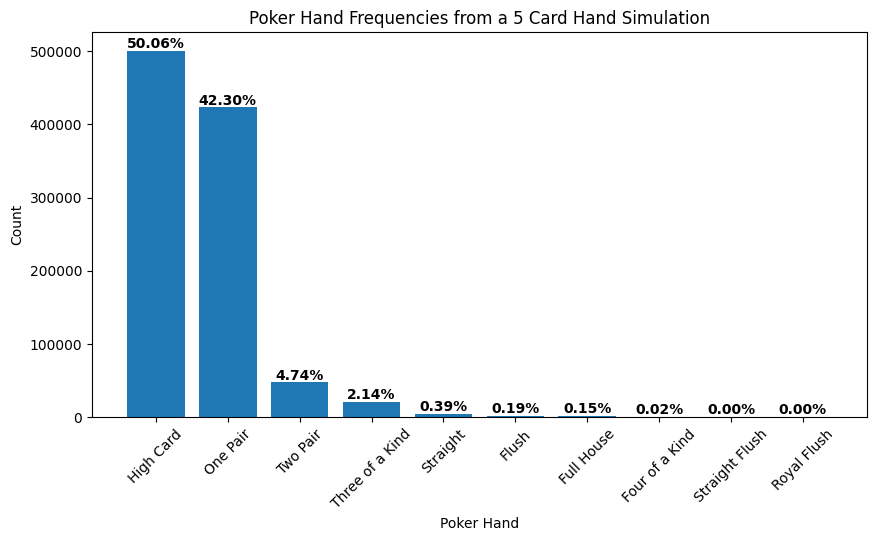

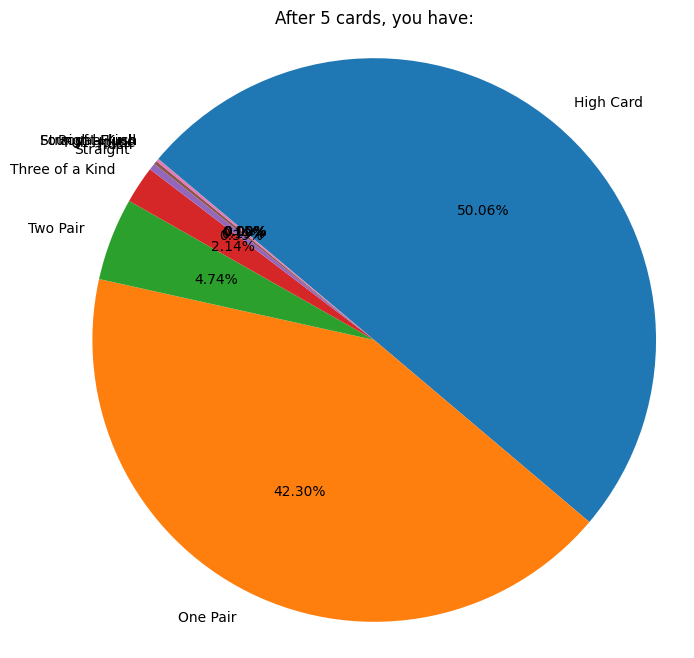

,Hand,Count,Frequency (%)
0,High Card,500631,50.0631
1,One Pair,422968,42.2968
2,Two Pair,47439,4.7439
3,Three of a Kind,21418,2.1418
4,Straight,3933,0.3933
5,Flush,1898,0.1898
6,Full House,1472,0.1472
7,Four of a Kind,223,0.0223
8,Straight Flush,15,0.0015
9,Royal Flush,3,0.0003


In [4]:

# Run simulation and display results
# sim5_stats = simulation5(100_000_000)
sim5_stats = None
# parallelize this over n=10 cores
def run_simulation5(num_trials: int = 100000) -> np.ndarray:
    return simulation5(num_trials)

from joblib import Parallel, delayed
num_trials = 1000000
num_workers = 10
sim5_stats = Parallel(n_jobs=num_workers)(delayed(run_simulation5)(num_trials // num_workers) for _ in range(num_workers))
sim5_stats = np.sum(sim5_stats, axis=0)









plt.figure(figsize=(10,5))
bars = plt.bar(POKER_HANDS, sim5_stats)
plt.ylabel('Count')
plt.xlabel('Poker Hand')
plt.title('Poker Hand Frequencies from a 5 Card Hand Simulation')
plt.xticks(rotation=45)

# Add percentages on top of bars
percentages = 100 * sim5_stats / sim5_stats.sum()
for bar, pct in zip(bars, percentages):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{pct:.2f}%',
             ha='center', va='bottom', fontsize=10, fontweight='bold')
plt.show()

# Pie chart of frequencies
plt.figure(figsize=(8,8))
plt.pie(sim5_stats, labels=POKER_HANDS, autopct='%1.2f%%', startangle=140, counterclock=False)
plt.title('After 5 cards, you have:')
plt.axis('equal')
plt.show()

import pandas as pd
df = pd.DataFrame({'Hand': POKER_HANDS, 'Count': sim5_stats})
df['Frequency (%)'] = percentages
df.sort_values('Count', ascending=False, inplace=True)
df.reset_index(drop=True, inplace=True)
df

In [5]:
# how much more likely is a flush to a fullhouse
flush_count = sim5_stats[POKER_HANDS.index("Flush")]
full_house_count = sim5_stats[POKER_HANDS.index("Full House")]
flush_to_full_house_ratio = flush_count / full_house_count if full_house_count > 0 else float('inf')
print(f"Flush is {flush_to_full_house_ratio:.2f} times more likely than Full House in a 5 card hand.")

Flush is 1.29 times more likely than Full House in a 5 card hand.


In [6]:
Hand(2)

[ K♠ 9♥ ]

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages

POKER_HANDS = [
    "High Card", "One Pair", "Two Pair", "Three of a Kind",
    "Straight", "Flush", "Full House", "Four of a Kind",
    "Straight Flush", "Royal Flush"
]

def make_section(axs_row, stats: np.ndarray, title_prefix: str):
    percentages = 100 * stats / stats.sum()

    # --- Bar chart ---
    ax_bar = axs_row[0]
    bars = ax_bar.bar(POKER_HANDS, stats)
    ax_bar.set_title(f'{title_prefix} - Bar Chart')
    ax_bar.set_ylabel('Count')
    ax_bar.set_xticklabels(POKER_HANDS, rotation=45, ha='right')
    for bar, pct in zip(bars, percentages):
        ax_bar.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{pct:.2f}%',
                    ha='center', va='bottom', fontsize=8, fontweight='bold')

    # --- Pie chart ---
    ax_pie = axs_row[1]
    ax_pie.pie(stats, labels=POKER_HANDS, autopct='%1.2f%%', startangle=140, counterclock=False)
    ax_pie.set_title(f'{title_prefix} - Pie Chart')

    # --- Table ---
    ax_table = axs_row[2]
    df = pd.DataFrame({'Hand': POKER_HANDS, 'Count': stats, 'Frequency (%)': percentages})
    df.sort_values('Count', ascending=False, inplace=True)
    df.reset_index(drop=True, inplace=True)
    ax_table.axis('off')
    table = ax_table.table(cellText=df.values, colLabels=df.columns, loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(8)
    table.scale(1.1, 1.5)
    ax_table.set_title(f'{title_prefix} - Table', fontweight='bold')

def generate_landscape_report(stats_7card: np.ndarray, stats_5card: np.ndarray, pdf_path: str):
    fig, axs = plt.subplots(2, 3, figsize=(18, 10))  # 2 rows (7-card, 5-card), 3 columns (bar, pie, table)
    plt.subplots_adjust(hspace=0.4, wspace=0.3)

    # Row 0: 7-card
    make_section(axs[0], stats_7card, "7-Card Simulation")

    # Row 1: 5-card
    make_section(axs[1], stats_5card, "5-Card Simulation")

    with PdfPages(pdf_path) as pdf:
        pdf.savefig(fig, bbox_inches='tight')
    plt.close(fig)

# Usage example:
# generate_landscape_report(sim7_stats, sim5_stats, "your_report.pdf")
def generate_portrait_report(stats_7card: np.ndarray, stats_5card: np.ndarray, pdf_path: str):
    fig, axs = plt.subplots(2, 3, figsize=(8.5, 11))  # Portrait layout
    plt.subplots_adjust(hspace=0.5, wspace=0.4)

    def make_section(axs_row, stats: np.ndarray, title_prefix: str):
        percentages = 100 * stats / stats.sum()

        # Bar chart
        ax_bar = axs_row[0]
        bars = ax_bar.bar(POKER_HANDS, stats)
        ax_bar.set_title(f'{title_prefix} - Bar Chart')
        ax_bar.set_ylabel('Count')
        ax_bar.set_xticklabels(POKER_HANDS, rotation=45, ha='right')
        for bar, pct in zip(bars, percentages):
            ax_bar.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{pct:.2f}%',
                        ha='center', va='bottom', fontsize=8, fontweight='bold')

        # Pie chart
        ax_pie = axs_row[1]
        ax_pie.pie(stats, labels=POKER_HANDS, autopct='%1.2f%%', startangle=140, counterclock=False)
        ax_pie.set_title(f'{title_prefix} - Pie Chart')

        # Table
        ax_table = axs_row[2]
        df = pd.DataFrame({'Hand': POKER_HANDS, 'Count': stats, 'Frequency (%)': percentages})
        df.sort_values('Count', ascending=False, inplace=True)
        df.reset_index(drop=True, inplace=True)
        ax_table.axis('off')
        table = ax_table.table(cellText=df.values, colLabels=df.columns, loc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(8)
        table.scale(1.1, 1.5)
        ax_table.set_title(f'{title_prefix} - Table', fontweight='bold')

    # Row 0: 7-card sim
    make_section(axs[0], stats_7card, "7-Card Simulation")

    # Row 1: 5-card sim
    make_section(axs[1], stats_5card, "5-Card Simulation")

    with PdfPages(pdf_path) as pdf:
        pdf.savefig(fig, bbox_inches='tight')
    plt.close(fig)

# Example usage:
generate_landscape_report(sim7_stats, sim5_stats, "poker_hand_simulation_report.pdf")
generate_portrait_report(sim7_stats, sim5_stats, "poker_hand_simulation_report_portrait.pdf")

/var/folders/k1/8prjln590qxc6f3c26mf_f100000gn/T/ipykernel_70742/4066526162.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_bar.set_xticklabels(POKER_HANDS, rotation=45, ha='right')
/var/folders/k1/8prjln590qxc6f3c26mf_f100000gn/T/ipykernel_70742/4066526162.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_bar.set_xticklabels(POKER_HANDS, rotation=45, ha='right')
/var/folders/k1/8prjln590qxc6f3c26mf_f100000gn/T/ipykernel_70742/4066526162.py:70: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_bar.set_xticklabels(POKER_HANDS, rotation=45, ha='right')
/var/folders/k1/8prjln590qxc6f3c26mf_f100000gn/T/ipykernel_70742/4066526162.py:70: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_

In [8]:
x = [1,2,3,4,5]
x[1:6]

[2, 3, 4, 5]